Hello, I am Dmitry, your team lead for this project. I will focus on checking your plan and your report. I may look through your code lightly if I need to link your plan/report back to the data.

You will find my comments in the boxes like these

<div class="alert alert-block alert-success">
<b>Success/Comment:</b> everything looks good, done correctly or it's just a generic comment.
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> warnings, non-critical issues; eliminating them can make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> there is something critical which requires correction, a project is not accepted with open red comments.
</div>

</span>

<font color='orange'>**2020-09-27 General Feedback on Plan**</font>

Unfortunately, I have not found the plan. It looks like you know what you are doing so I am accepting your current work without the explicit plan but if you could please add it to the next iteration.

I have looked through your code. I understand you are trying to engineer new set of feautures in a Machine Learning way, with PCA and Clustering. I believe this is not necessary for this project, it will likely consume a lot of time and do not lead to any significant improvemnet. Try to start with basic models and add complexity to them if required.

I'll be waiting for your project with the plan and the report. Again, my advice is to start with the basic set of features to build a baseline. Components from PCA and clusters can be added later to check if they can bring any quality improvement over the baseline.

### Background Information

In order to optimize production costs, the steel plant Steelproof decided to reduce their energy consumption at the steel processing stage. You'll have to develop a model that will be able to predict the temperature of the metal.

### Questions to answer

- What are the row levels for each datasets? How to make each row represents only one line item?
- How to identify features that contain only a small portion of information?
- What are some of the steps taken for engineering new features?

### Methodologies

- Use the groupby method for resetting row levels
- Identify unuseful features by determine unique values, missing value proportions, and collinearity
- Extract hour/minute value from timstamps to form new featuture, use clustering results as new feature, 
- Filling in missing values use the mode value from the corrosponding features 

<div class="alert alert-block alert-success">
Just a slight correction. The 'groupby' operation (or method) is used to calculate aggregative values i.e. values aggregated over a group. The result is one value per group (several rows).
</div>

<div class="alert alert-block alert-info">
<p>Wow, that's a handy class! I have googled for it and it looks like it was borrowed from https://github.com/WillKoehrsen/feature-selector. Added to my booksmarks.</p>
    
However, for the purpose of education, it's better to not use such helping classes as they mask simple but important to understand logic.
</div>

# Code Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Thank you for turning in the project! You did a pretty good job overall! You did a very nice EDA and the model training section is not bad, but there are a couple of problems that need to be fixed before the project can be accepted. See my comments below for more information. Good luck!

<div class="alert alert-danger">
    <s>Hi! I noticed one problem I seem to have missed the first time around: you evaluate your lightgbm model on test prior to selecting the features and hyperparameters, which kind of defeats the purpose of the test set: it should be the set that doesn't influence your decisions about the model at all and is left untouched until after you finish all the work on the model to evaluate its performance on new unseen data. This is what the validation set is for.</s>
</div>

<div class="alert alert-success">
    Hi! Now that you've fixed that problem, the project is accepted! Based on the test set MAE of your final model, you got 4 SP. Well done!
</div>

### Load Data

In [1]:
# import libraries

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, plotting

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import datasets

arc = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_arc_en.csv')
bulk = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_bulk_en.csv')
bulk_time = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_bulk_time_en.csv')
gas = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_gas_en.csv')
temp = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_temp_en.csv')
wire = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_wire_en.csv')
wire_time = pd.read_csv(r'C:\Users\607991\Desktop\final_steel_en\data_wire_time_en.csv')

In [ ]:
# since the 'key' column is used as the main differentiator in each dataset,
# we will use this column to inspect row level for each dataset

print('The arc dataset has', len(arc.query('key==1')), 'rows that are associated with key #1')
print('The bulk dataset has', len(bulk.query('key==1')), 'rows that are associated with key #1')
print('The bulk_time dataset has', len(bulk_time.query('key==1')), 'rows that are associated with key #1')
print('The gas dataset has', len(gas.query('key==1')), 'rows that are associated with key #1')
print('The temp dataset has', len(temp.query('key==1')), 'rows that are associated with key #1')
print('The wire dataset has', len(wire.query('key==1')), 'rows that are associated with key #1')
print('The wire_time dataset has', len(wire_time.query('key==1')), 'rows that are associated with key #1')

### Exploratory Data Analysis

In [4]:
# the missing values in data_temp.csv result from a failure in measurement, so all keys that contain only the 
# starting temperature must be removed

temp_keys_with_zero = np.where(temp.Temperature.isnull(), temp.key, 0)
temp_keys_with_zero = np.setdiff1d(temp_keys_with_zero, [0]).tolist()
temp_keys_to_remove = temp.query('key==@temp_keys_with_zero').index
temp.drop(temp_keys_to_remove, axis=0, inplace=True)

# additional assignment #1: The duration between the first and last temperature measurement

temp['Sampling time'] = pd.to_datetime(temp['Sampling time'], format='%Y-%m-%d %H:%M:%S')
temp_df1 = []    # differences between the first and the last temperatures
temp_df2 = []    # elapsed time measured in seconds

for each in temp.key.unique():
    temp_diff = temp.query('key==@each').iloc[len(temp.query('key==@each'))-1].Temperature - \
    temp.query('key==@each').iloc[0].Temperature
    temp_df1.append(temp_diff)
    
    time_delta = temp.query('key==@each').iloc[len(temp.query('key==@each'))-1,1] - \
    temp.query('key==@each').iloc[0,1]
    temp_df2.append(time_delta.seconds)

temp_df1 = pd.DataFrame(data=temp_df1, index=temp.key.unique(), columns=['Temperature diff'])
temp_df2 = pd.DataFrame(data=temp_df2, index=temp.key.unique(), columns=['Seconds elapsed'])

# to fix the row level, we will only get the last recorded temperature as our target values

temp_df3 = []

for each in temp.key.unique():
    temp_df3.append(temp.query('key==@each').iloc[len(temp.query('key==@each'))-1].Temperature)

temp_df3 = pd.DataFrame(data=temp_df3, index=temp.key.unique(), columns=['Temperature'])

# merge the previously created features with the chosen temperature column

temp_df = temp_df3.join(temp_df2).join(temp_df1)

In [5]:
# the next task is to preprocessing the arc dataset so that they have the same number of batches per key number

# additional assignment #2: The total electrode heating time 
# (i.e. the sum of the values for all intervals between the electrode heating launches)
#
# additional assignment #3: The number of electrode heating launches

arc['Arc heating start'] = pd.to_datetime(arc['Arc heating start'], format='%Y-%m-%d %H:%M:%S')
arc['Arc heating end'] = pd.to_datetime(arc['Arc heating end'], format='%Y-%m-%d %H:%M:%S')

arc_temp1 = []    # record total electrode heating time
arc_temp2 = []    # record number of electrode heating launches

for each in arc.key.unique():    
    time_delta = arc.query('key==@each').iloc[len(arc.query('key==@each'))-1,2] - \
    arc.query('key==@each').iloc[0,1]
    arc_temp1.append(time_delta.seconds)
    arc_temp2.append(len(arc.query('key==@each'))*2)
    
arc_df1 = pd.DataFrame(data=arc_temp1, index=arc.key.unique(), columns=['Arc heating time elapsed'])
arc_df2 = pd.DataFrame(data=arc_temp2, index=arc.key.unique(), columns=['Arc heating launches'])

# create a new feature, combined power, then groupby each key value

arc['Combined power'] = arc['Active power'] + arc['Reactive power']
arc = pd.DataFrame(arc.groupby('key').sum()['Combined power'], index=arc.key.unique(), columns=['Combined power'])

# merge the grouby arc dataset with the newly created arc datasets

arc_df = arc.join(arc_df1).join(arc_df2)

In [6]:
# join all the given datasets into one dataset before perform general data cleasing steps

bulk.set_index('key', inplace=True)
bulk_time.set_index('key', inplace=True)
gas.set_index('key', inplace=True)
wire.set_index('key', inplace=True)
wire_time.set_index('key', inplace=True)

df = temp_df.join(arc_df).join(gas).join(bulk).join(bulk_time, rsuffix='_time').join(wire).join(wire_time, rsuffix='_time')

In [7]:
# begin data exploration 

from FeatureEngineering import FeatureSelector

labels = df['Temperature']
df = df.drop(columns = ['Temperature'])

fs = FeatureSelector(data = df, labels=labels)# create the instance

2 features with greater than 1.00 missing values.



,missing_fraction
Wire 5_time,1.000000
Wire 5,1.000000
Bulk 8_time,0.999596
Bulk 8,0.999596
Wire 7,0.998385
Wire 7_time,0.998385
Wire 4_time,0.995155
Wire 4,0.995155
Wire 8_time,0.994752
Bulk 2,0.994752


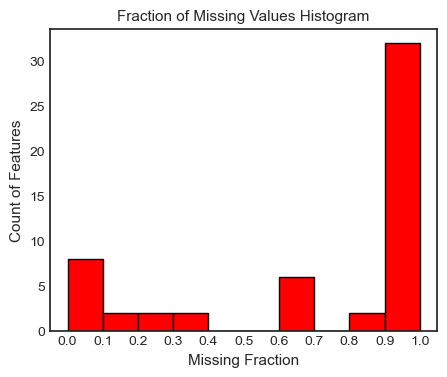

In [8]:
# missing values

fs.identify_missing(missing_threshold=.9999)    # features with large number missing values
missing_features = fs.ops['missing']          # features identified for removal
fs.plot_missing()                             # plot a histogram of the missing column fraction
fs.missing_stats.head(10)                     # detailed information on missing fractions

2 features with a single unique value.



,nunique
Wire 5,0
Wire 5_time,0
Bulk 8_time,1
Bulk 8,1
Wire 7_time,4


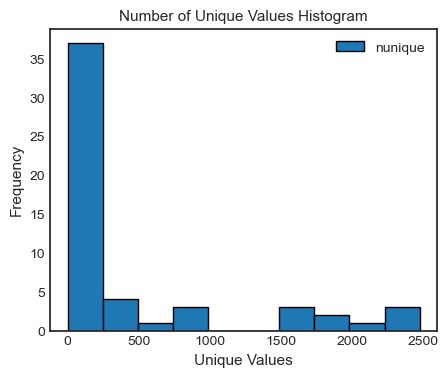

In [9]:
# single unique value
# find any features that have only a single unique value.
# this does not one-hot encode variables.

fs.identify_single_unique()
single_unique = fs.ops['single_unique']
fs.plot_unique()
fs.unique_stats.head()

In [10]:
# drop the unneccessary features

vars_to_drop = single_unique + missing_features
df.drop(columns=vars_to_drop, inplace=True)

<div class="alert alert-danger">
    <s>Very nice EDA! The only problem is that the missing values in data_temp.csv result from a failure in measurement, so all keys that contain only the starting temperature must be removed.</s>
</div>

<div class="alert alert-success">
    Ok, fixed now!
</div>

### Data Processing

In [11]:
# preparing the original set of features to be used in a baseline model
# extract time related information to create new features

vars_time = [col for col in df.columns if '_time' in col]

for each in vars_time:
    df[each] = pd.to_datetime(df[each], format='%Y-%m-%d %H:%M:%S')
    
for each in vars_time:
    df[each +'_month'] = df[each].dt.month
    df[each +'_day'] = df[each].dt.day
    df[each +'_min'] = df[each].dt.round('1min').dt.minute
    df[each +'_hour'] = df[each].dt.hour

for each in vars_time:
    df.drop(each, axis=1, inplace=True)

In [12]:
# create train and test sets

x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.15, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=123)

# filling missing values for the val and test sets using the modes gathered from the train set

vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]
for var in vars_with_na:
    
    # calculate the mode
    mode_val = x_train[var].mode()[0]
    
    # replace missing values by the mode
    x_train[var] = x_train[var].fillna(mode_val)
    x_val[var] = x_val[var].fillna(mode_val)
    x_test[var] = x_test[var].fillna(mode_val)

In [13]:
# scaling

cols = x_train.columns.tolist()
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_train = pd.DataFrame(data=x_train, columns=cols)

x_val = scaler.transform(x_val)
x_val = pd.DataFrame(data=x_val, columns=cols)

x_test = scaler.transform(x_test)
x_test = pd.DataFrame(data=x_test, columns=cols)

In [14]:
# last check for missing values

print([var for var in x_train.columns if x_train[var].isnull().sum() > 0])
print([var for var in x_val.columns if x_val[var].isnull().sum() > 0])
print([var for var in x_test.columns if x_test[var].isnull().sum() > 0])

[]
[]
[]


<div class="alert alert-danger">
    <s><ul>
        <li>If you want to fill missing values not with something trivial (like 0), but using some statistics of the data (e.g. mode, mean, median, etc.), you need to calculate the statistics using only the train set. Otherwise you introduce knowledge about the test set into the train set, which kind of defeats the point of using a hold-out set to evaluate the model's performance on new unseen data.</li>
        <li>The same applies to using MinMaxScaler or StandardScaler or anything similar. It has to be fit using only the train set, and then you can transform the validation and test sets. Note that tree-based models don't require scaling the data and will happily work with unscaled data.</li>
        <li>For those reasons, k-fold cross-validation using cross_val_score on the scaled data with missing values filled will overestimate the performance of your models, but I guess it's not that big of a problem if you evaluate the final model on the unseen test set.</li>
        </ul></s>
</div>

<div class="alert alert-warning">
    Ok, now it's better. But if you do cross-validation, you should really do all of this stuff inside something like <a href='https://scikit-learn.org/stable/modules/compose.html'>sklearn's Pipeline</a>
</div>

<div class="alert alert-warning">
    <ul>
        <li>Would be nice if you included a list/summary of features you use for training the models.</li>
        <li>It doesn't seem productive to use month/day/hour/minute features: the process should not depend on what time/day it is.</li>
    </ul>
</div>

### Modeling

The plan is to first use the original set of features in a predictive model to create a baseline. Then going through the following steps in the subsequent iterations to improve the baseline model.
- Hyper-parameter tuning
- Examining model's learning curve
- Try using the new set of feature and determine their potential predictive usefulness

In [15]:
# create a baseline model using ElasticNet

baseline = cross_val_score(ElasticNet(random_state=123, selection='random'), x_train, y_train, 
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, error_score='raise')

print('Baseline MAE from using ElasticNet is: %.3f' % baseline.mean())

Baseline MAE from using ElasticNet is: -9.820


In [16]:
# utilize potentially better modeling algorithms to be applied to the original dataset

lgb = LGBMRegressor(random_state=123)
lgb.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_val, y_val)],
         eval_metric= 'mae', early_stopping_rounds=30, verbose=20)

y_pred = lgb.predict(x_val)
print('Improved MAE from using LightGBM Regressor is: %.3f' % mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 30 rounds
[20]	training's l1: 6.2047	training's l2: 77.7526	valid_1's l1: 8.06744	valid_1's l2: 135.122
[40]	training's l1: 4.97608	training's l2: 49.0249	valid_1's l1: 7.76196	valid_1's l2: 122.56
[60]	training's l1: 4.21934	training's l2: 34.9366	valid_1's l1: 7.69759	valid_1's l2: 118.23
[80]	training's l1: 3.62264	training's l2: 25.6167	valid_1's l1: 7.6591	valid_1's l2: 115.518
[100]	training's l1: 3.16421	training's l2: 19.5244	valid_1's l1: 7.68765	valid_1's l2: 115.54
Did not meet early stopping. Best iteration is:
[100]	training's l1: 3.16421	training's l2: 19.5244	valid_1's l1: 7.68765	valid_1's l2: 115.54
Improved MAE from using LightGBM Regressor is: 7.688


<div class="alert alert-danger">
    <s>You should evaluate your model on the test set only after selecting features/hyperparameters etc. using cross-validation</s>
</div>

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 7.42415	valid_0's l2: 104.104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 6.89162	valid_0's l2: 84.8336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's l1: 7.16631	valid_0's l2: 93.2415
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 7.16112	valid_0's l2: 107.735
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 7.49685	valid_0's l2: 115.49
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 7.27549	valid_0's l2: 102.224
Training until validation scores don't improve for 100 rounds
Early stopping, best ite

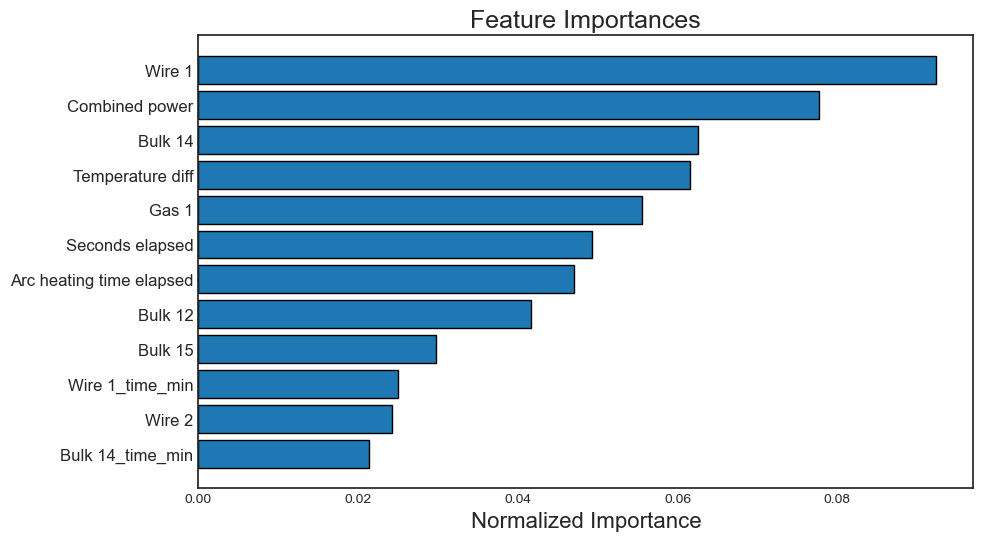

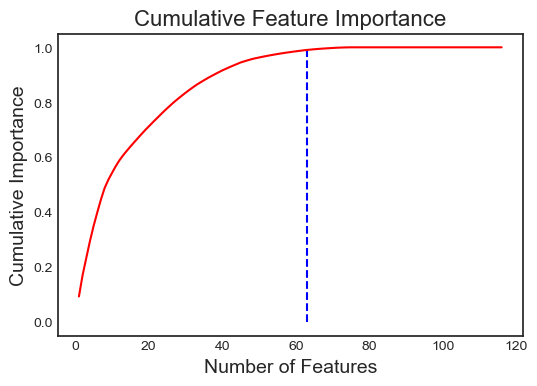

63 features required for 0.99 of cumulative importance


In [17]:
# examine feature importance

fs.identify_zero_importance(task = 'regression', eval_metric = 'mae', n_iterations = 10, early_stopping = True)
zero_importance_features = fs.ops['zero_importance']
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [18]:
# eliminate zero importance features

x_train_new = x_train.drop(zero_importance_features, axis=1)
x_val_new = x_val.drop(zero_importance_features, axis=1)
x_test_new = x_test.drop(zero_importance_features, axis=1)

lgb = LGBMRegressor(random_state=123)
lgb.fit(x_train_new, y_train, eval_set = [(x_train_new, y_train), (x_val_new, y_val)],
         eval_metric= 'mae', early_stopping_rounds=30, verbose=20)

y_pred_new = lgb.predict(x_val_new)
print('After feature selection, improved MAE from using LightGBM Regressor is: %.3f' % mean_absolute_error(y_val, y_pred_new))

Training until validation scores don't improve for 30 rounds
[20]	training's l1: 6.2047	training's l2: 77.7526	valid_1's l1: 8.06744	valid_1's l2: 135.122
[40]	training's l1: 4.97608	training's l2: 49.0249	valid_1's l1: 7.76196	valid_1's l2: 122.56
[60]	training's l1: 4.21934	training's l2: 34.9366	valid_1's l1: 7.69759	valid_1's l2: 118.23
[80]	training's l1: 3.62264	training's l2: 25.6167	valid_1's l1: 7.6591	valid_1's l2: 115.518
[100]	training's l1: 3.16421	training's l2: 19.5244	valid_1's l1: 7.68765	valid_1's l2: 115.54
Did not meet early stopping. Best iteration is:
[100]	training's l1: 3.16421	training's l2: 19.5244	valid_1's l1: 7.68765	valid_1's l2: 115.54
After feature selection, improved MAE from using LightGBM Regressor is: 7.688


<div class="alert alert-danger">
    <s>You should evaluate your model on the test set only after selecting features/hyperparameters etc. using cross-validation</s>
</div>

In [19]:
# hyperparameter search space

import time
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

lgb_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 100, 1)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 100.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 100.0),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 2, 100, 5)),
}

In [20]:
def hyperopt(estimator, param_space, X_train, y_train, X_test, y_test, num_eval, eval_metric=None):
    
    start = time.time()
    
    def objective_function(params):
        model = estimator(**params)
        score = cross_val_score(model, X_train, y_train, cv=3, scoring=eval_metric).mean()
        return {'loss': -score, 'status': STATUS_OK}

    
    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    
    if str(estimator) == "<class 'lightgbm.sklearn.LGBMRegressor'>":
        
        for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
            best_param[each] = int(best_param[each])
        
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        y_pred = model_best.predict(X_test)
        
    
    if str(estimator) == "<class 'xgboost.sklearn.XGBRegressor'>":
         
        for each in ['n_estimators','max_depth','min_child_weight']:
            best_param[each] = int(best_param[each])
                
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        y_pred = model_best.predict(X_test)
        
    
    if str(estimator) == "<class 'catboost.core.CatBoostRegressor'>":
         
        for each in ['iterations','depth']:#,'min_child_samples','num_leaves']:
            best_param[each] = int(best_param[each])
                
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        test_pool = Pool(X_test)
        y_pred = model_best.predict(test_pool)

    
    print("")
    print("##### Results #####")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", mean_absolute_error(y_test, y_pred))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    
    return trials

In [21]:
num_eval=50
eval_metric = 'neg_mean_absolute_error'
lgb_hyperopt = hyperopt(LGBMRegressor, lgb_space, x_train_new, y_train, x_val_new, y_val, num_eval, eval_metric)

100%|███████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s, best loss: 7.6102080754008865]

##### Results #####
Score best parameters:  -7.6102080754008865
Best parameters:  {'bagging_fraction': 0.8613654380678865, 'colsample_by_tree': 0.6449337553495736, 'learning_rate': 0.0167064368361553, 'max_depth': 7, 'min_child_samples': 0, 'n_estimators': 408, 'num_leaves': 34, 'reg_alpha': 25.08191511651788, 'reg_lambda': 6.9947748624493356}
Test Score:  7.555574666272897
Time elapsed:  50.24963855743408
Parameter combinations evaluated:  50


In [22]:
# unpack the selected parameters

unpack_function = lambda l: [item for sublist in l for item in sublist]
unpack_all = lgb_hyperopt.best_trial['misc']['vals']
unpack_values = [i for i in unpack_all.values()]
values = unpack_function(unpack_values)
keys = [i for i in unpack_all.keys()]
best_param = {keys[i]: values[i] for i in range(len(keys))} 

for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
    best_param[each] = int(best_param[each])

In [23]:
# final model performance assessment

lgb = LGBMRegressor(**best_param)
lgb.fit(x_train_new, y_train, eval_set = [(x_train_new, y_train), (x_val_new, y_val)],
         eval_metric= 'mae', early_stopping_rounds=30, verbose=20)

y_pred_final = lgb.predict(x_test_new)
print('Final MAE from using LightGBM Regressor is: %.3f' % mean_absolute_error(y_test, y_pred_final))

Training until validation scores don't improve for 30 rounds
[20]	training's l1: 8.74627	training's l2: 170.134	valid_1's l1: 9.88856	valid_1's l2: 235.459
[40]	training's l1: 7.99826	training's l2: 133.758	valid_1's l1: 9.26404	valid_1's l2: 191.642
[60]	training's l1: 7.45192	training's l2: 110.547	valid_1's l1: 8.83808	valid_1's l2: 164.359
[80]	training's l1: 7.00419	training's l2: 95.123	valid_1's l1: 8.54224	valid_1's l2: 147.153
[100]	training's l1: 6.62354	training's l2: 84.0205	valid_1's l1: 8.31545	valid_1's l2: 136.071
[120]	training's l1: 6.30809	training's l2: 75.8499	valid_1's l1: 8.13908	valid_1's l2: 129.743
[140]	training's l1: 6.05569	training's l2: 69.8641	valid_1's l1: 7.99481	valid_1's l2: 125.78
[160]	training's l1: 5.85167	training's l2: 65.1363	valid_1's l1: 7.88079	valid_1's l2: 122.9
[180]	training's l1: 5.67014	training's l2: 61.1681	valid_1's l1: 7.81152	valid_1's l2: 120.932
[200]	training's l1: 5.55673	training's l2: 58.5783	valid_1's l1: 7.77198	valid_1's

In [24]:
# examine model learning curve

def learning_curve_graph(model, x, y, scorer, tune_params, tune_result, title, x_label, y_label):

    # Initialize a learning curve figure

    fig, axes = plt.subplots(1, 1, figsize=(8, 7))
    axes.set_title(title)
    axes.set_ylim(tune_result[0], tune_result[1])
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)

    # learning curve calculations

    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    train_sizes, train_scores, test_scores = \
    learning_curve(model(**tune_params), 
                   x, y, scoring=scorer,
                   cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the curve

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    axes.legend(loc="best")

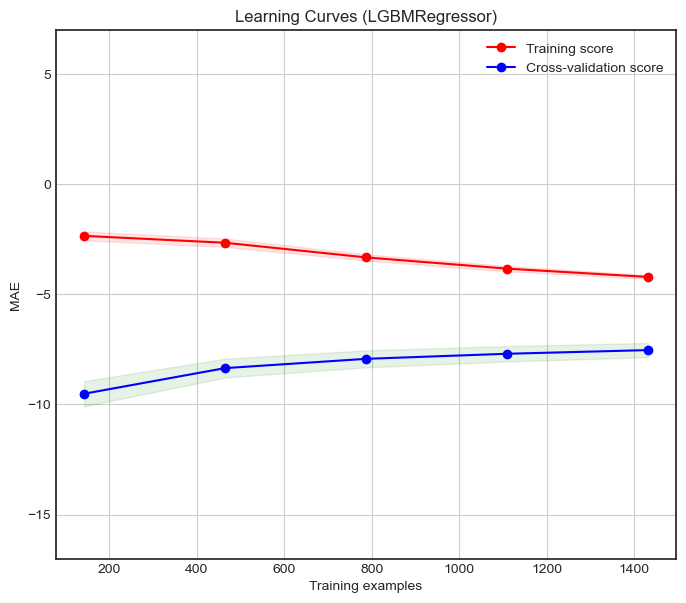

In [25]:
model = LGBMRegressor
x = x_train_new
y = y_train
scorer = 'neg_mean_absolute_error'
tune_params = best_param
tune_result = [-17, 7]
title = "Learning Curves (LGBMRegressor)"
x_label = "Training examples"
y_label = "MAE"

learning_curve_graph(model, x, y, scorer, tune_params, tune_result, title, x_label, y_label)

- Final model's performance is justified by examing its learning curve
- It is highly suspected that the modeling error could be further reduced to MAE 5 when more data is introduced. 

<div class="alert alert-danger">
    <s>The model training section is very nice! You tried a couple of models, tuned LGBM's hyperparameters using cross-validation and reached a pretty good score. It's great that you looked at feature importances and learning curves! That's a nice way to gain insight into your model. Unfortunately due to problems with the data you'll have to revisit the conclusions of this section after correcting the data processing.</s>
</div>

<div class="alert alert-success">
    Fixed! Good job!
</div>

### Report

Questions to be answered:
- What steps of the plan were performed and what steps were skipped (explain why)?
- What difficulties did you encounter and how did you manage to solve them?
- What were some of the key steps to solving the task?
- What is your final model and what quality score does it have?

1. After loading the data, the first step taken was to fix the row levels of the arc and the temperature dataset. Additional requirements given in the description were met (3 out of 4) during this process. As a result, new features were created. Then all dataset were joined together using the 'key' column as the reference. The resulted dataset is being used as the first version of the finalized data which is to be used in the data cleaning and modeling process. 

    During the data cleaning process, 2 features were identified as having large proportion of missing values, while another 2 features were identified as having only 1 value throughout the entire dataset. Lastly, a number of steps were taken during the modeling process namely feature selection, hyperparameter tuning and learning curve. Once features are finalized and the chosen model is tuned, we will used the final test set to determine the performance of the final model.

2. The main challenge encounterd was to remove the rows from the temperature dataset that has missing values. To solve this challenge, we first identified the associated key values then looked at the row index of these key values. After locating through the row index, we are ready to remove these rows.

    The second challenge faced was to fix the row levels presented in the arc and temperature dataset. For example, there are multiple rows all assigned to the same key value. Groupby sum method was used in the arc dataset to aggregate for each key value, while the last temperature of each key value was recorded as the target values. 

3. Some of the key steps I took to solve the task include estalishing a baseline performance by using a linear regressor. Then choose a tree-based modeling method to compare the performance and choose the one that shows greater potential. Feature selection and hyperparameter tuning is perform after a modeling framework is chosen. Lastly, final model's learning curve is examined to make sure that the model does not over/under fit.

4. The final model is a LightGBM regressor with a test MAE of 8.4